# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Business Problems
In this notebook, I will answer these questions:
1. What are the main features that impact offer effectiveness?
2. Can we predict whether a user will complete the offer sent to them?

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [2]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Understanding

### 1. Portfolio

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# Check type and null values
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### 2. Profile

In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
# Check type and null values
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
# Check people with 'age' 118 -> We see that all lines with 'age' = 118 also have null in 'gender' and 'income'
profile[profile.age == 118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [8]:
# Rename to 'customer_id'
profile = profile.rename(columns={'id': 'customer_id'})

profile

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


### 3. Transcript

In [9]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [10]:
# Check type and null values
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
# Count of unique events
transcript['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

# Data Wrangling

### 1. Portfolio

In [12]:
# Split 'channels' into 4 seperate columns
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

# Remove 'channels'
portfolio = portfolio.drop(columns = ['channels'])

# Rename to 'offer_id'
portfolio = portfolio.rename(columns={'id': 'offer_id'})

portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


### 2. Profile

In [13]:
# Remove 2175 rows having useless information
profile = profile.dropna()

profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   customer_id       14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [14]:
# Convert 'became_member_on' into datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

profile.head()

/var/folders/_s/ykdy6cd56w92znrywxw_lpj80000gn/T/ipykernel_1605/4004626166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')


,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


### 3. Transcript

In [15]:
# Extract the different values in 'value' column
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [16]:
# Check status
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   value     306534 non-null  object 
 3   time      306534 non-null  int64  
 4   offer id  134002 non-null  object 
 5   amount    138953 non-null  float64
 6   offer_id  33579 non-null   object 
 7   reward    33579 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 18.7+ MB


In [17]:
# Clean up the duplicates in offer id and offer_id and merge into one column
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'], transcript['offer id'])

# Drop unnecessary columns
transcript = transcript.drop(columns=['offer id', 'offer_id', 'value', 'reward'])

# Rename the 'offer_id' and 'customer_id' column
transcript = transcript.rename(columns={'clean_id': 'offer_id', 'person': 'customer_id'})

transcript.head()

,customer_id,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [18]:
# Split 'event' into 4 separate columns
transcript['offer_completed'] = transcript['event'].apply(lambda x: 1 if x == 'offer completed' else 0)
transcript['transaction'] = transcript['event'].apply(lambda x: 1 if x == 'transaction' else 0)
transcript['offer_viewed'] = transcript['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)
transcript['offer_received'] = transcript['event'].apply(lambda x: 1 if x == 'offer received' else 0)

# Drop 'event' column
transcript = transcript.drop(columns=['event'])

transcript.head()

,customer_id,time,amount,offer_id,offer_completed,transaction,offer_viewed,offer_received
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0,1
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,0,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,0,0,1
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0,1


In [19]:
# Drop duplicates
print(transcript.duplicated().sum())
transcript = transcript.drop_duplicates()

print(transcript.duplicated().sum())

397
0


### 4. Merging datasets

In [20]:
# Merge 'transcript' and 'portfolio'
df_merged = pd.merge(transcript, portfolio, on='offer_id', how='left')

df_merged

,customer_id,time,amount,offer_id,offer_completed,transaction,offer_viewed,offer_received,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0,1,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,0,0,1,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,0,0,1,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0,1,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306132,b3a1272bc9904337b331bf348c3e8c17,714,1.59,NaN,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306133,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,NaN,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306134,a00058cf10334a308c68e7631c529907,714,3.61,NaN,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306135,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,NaN,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Continue merging with 'profile'
df_master = pd.merge(df_merged, profile, on='customer_id', how='inner')

df_master

,customer_id,time,amount,offer_id,offer_completed,transaction,offer_viewed,offer_received,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272383,9fcbff4f8d7241faa4ab8a9d19c8a812,504,NaN,3f207df678b143eea3cee63160fa8bed,0,0,1,0,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,M,47,2017-10-13,94000.0
272384,9fcbff4f8d7241faa4ab8a9d19c8a812,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0,1,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,M,47,2017-10-13,94000.0
272385,9fcbff4f8d7241faa4ab8a9d19c8a812,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,1,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,M,47,2017-10-13,94000.0
272386,3045af4e98794a04a5542d3eac939b1f,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0,1,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,F,58,2016-10-20,78000.0


# Data Visualization

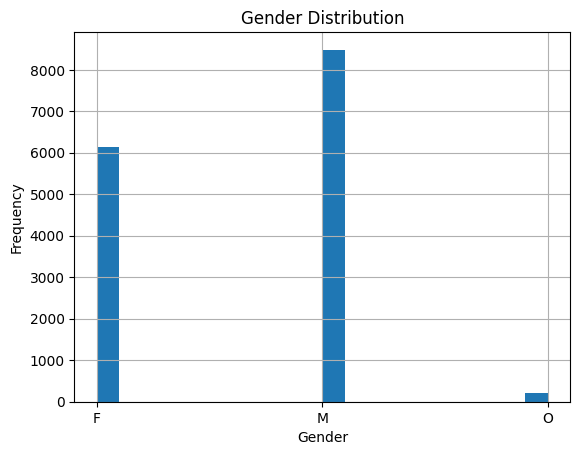

In [22]:
# Gender distribution
plt.hist(profile['gender'], bins=20)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution')
plt.grid(True)
plt.show()

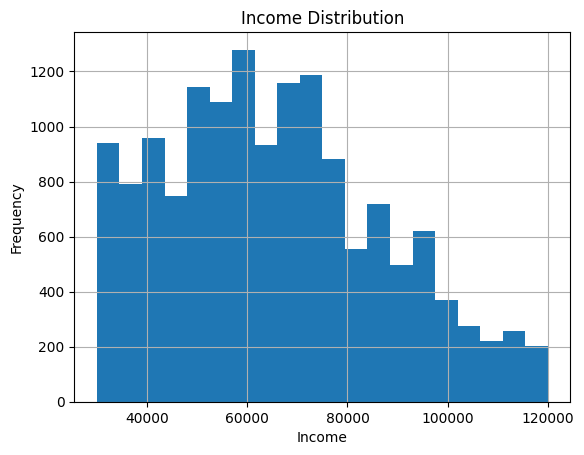

In [23]:
# Income distribution
plt.hist(profile['income'], bins=20)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.grid(True)
plt.show()

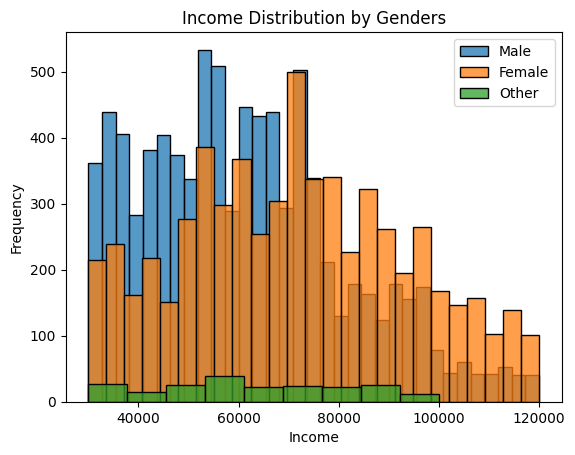

In [24]:
# Income Distribution by Genders
sns.histplot(profile[profile.gender=='M'].income, label='Male')
sns.histplot(profile[profile.gender=='F'].income, label='Female')
sns.histplot(profile[profile.gender=='O'].income, label='Other')
plt.legend()
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution by Genders')
plt.show()

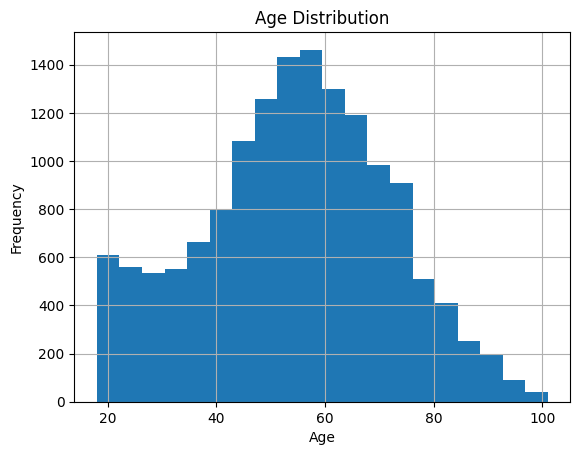

In [25]:
# Age distribution
plt.hist(profile['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.grid(True)
plt.show()

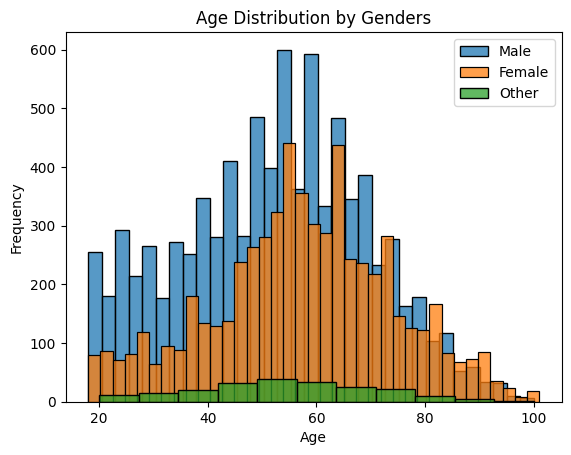

In [26]:
# Age Distribution by Genders
sns.histplot(profile[profile.gender=='M'].age, label='Male')
sns.histplot(profile[profile.gender=='F'].age, label='Female')
sns.histplot(profile[profile.gender=='O'].age, label='Other')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Genders')
plt.show()

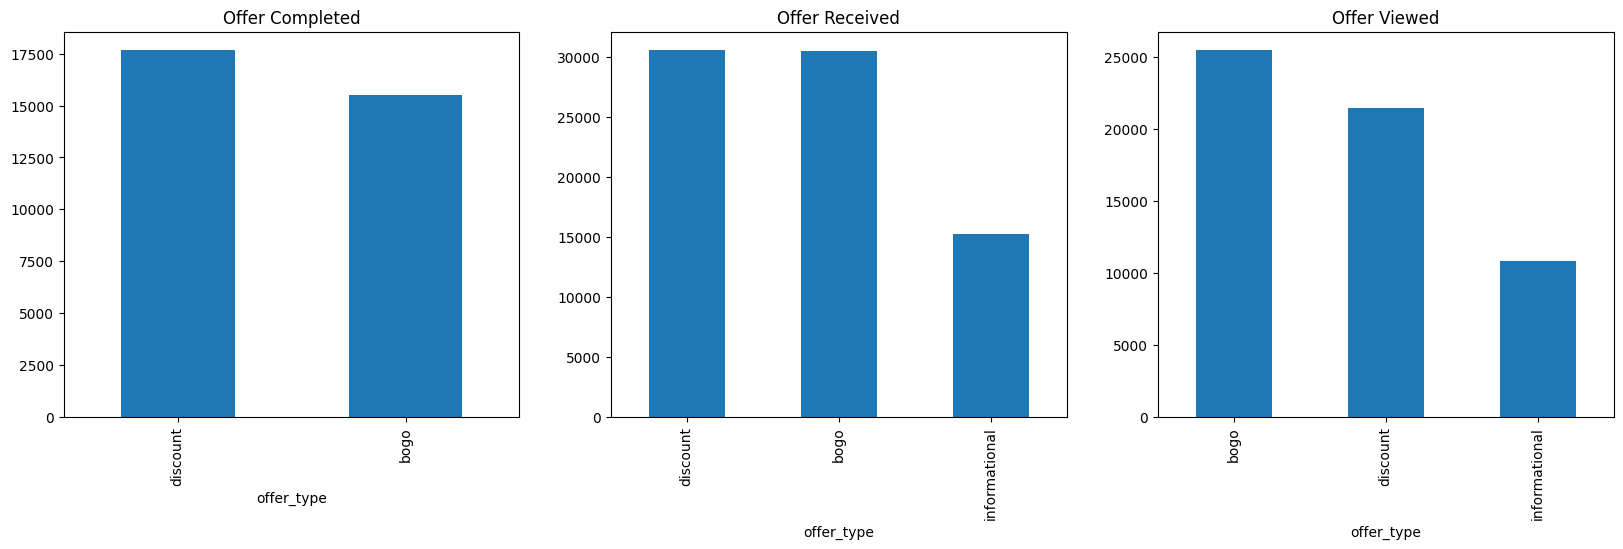

In [27]:
# Distibution of Offers
fig, ax = plt.subplots(1, 3, figsize = [20, 5])

ax3 = df_merged[df_merged.offer_completed == 1].offer_type.value_counts().plot(kind='bar', ax=ax[0])
ax3.title.set_text('Offer Completed');

ax1 = df_merged[df_merged.offer_received == 1].offer_type.value_counts().plot(kind='bar', ax=ax[1])
ax1.title.set_text('Offer Received');

ax2 = df_merged[df_merged.offer_viewed == 1].offer_type.value_counts().plot(kind='bar', ax=ax[2])
ax2.title.set_text('Offer Viewed');

# Data Preparation

In [28]:
df_master

,customer_id,time,amount,offer_id,offer_completed,transaction,offer_viewed,offer_received,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272383,9fcbff4f8d7241faa4ab8a9d19c8a812,504,NaN,3f207df678b143eea3cee63160fa8bed,0,0,1,0,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,M,47,2017-10-13,94000.0
272384,9fcbff4f8d7241faa4ab8a9d19c8a812,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0,1,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,M,47,2017-10-13,94000.0
272385,9fcbff4f8d7241faa4ab8a9d19c8a812,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,1,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,M,47,2017-10-13,94000.0
272386,3045af4e98794a04a5542d3eac939b1f,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0,1,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,F,58,2016-10-20,78000.0


In [29]:
# Extract 'year' from 'became_member_on'
df_master['member_year'] = df_master['became_member_on'].dt.year

df_master.head()

,customer_id,time,amount,offer_id,offer_completed,transaction,offer_viewed,offer_received,reward,difficulty,...,offer_type,web,email,mobile,social,gender,age,became_member_on,income,member_year
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,5.0,5.0,...,bogo,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0,2017
1,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5.0,5.0,...,bogo,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0,2017
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,0,1,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0,2017
3,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,...,bogo,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0,2017
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,0,1,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0,2017


In [30]:
# Encode 'gender'
df_master['gender'] = df_master['gender'].replace({'M': 2, 'F': 1, 'O': 0})

df_master['gender'].value_counts()

gender
2    155483
1    112940
0      3965
Name: count, dtype: int64

In [31]:
# Fill '0' to 'na' values
df_master = df_master.fillna(0)

df_master.isnull().sum()

customer_id         0
time                0
amount              0
offer_id            0
offer_completed     0
transaction         0
offer_viewed        0
offer_received      0
reward              0
difficulty          0
duration            0
offer_type          0
web                 0
email               0
mobile              0
social              0
gender              0
age                 0
became_member_on    0
income              0
member_year         0
dtype: int64

In [32]:
# Splitting sets

X = df_master[['time', 'amount','reward', 'difficulty', 'duration', 'age', 'income', 'gender', 'member_year']]
y =  df_master['offer_completed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204291, 9), (68097, 9), (204291,), (68097,))

# Data Modelling

In [46]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [34]:
# KNN Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
# Decision Tree
dec_tree = DecisionTreeClassifier(random_state=42)
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [36]:
# Random Forest
ran_for = RandomForestClassifier(random_state=42)
ran_for.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
# Gradient Boosting
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

# Results Evaluation

In [38]:
# Function to evaluate models

def evaluate_model(model, X_test=X_test, y_test=y_test):
    """
    Description: This function can be used to return the scores for one specific model in the defined test dataframes.

    Arguments:
    model: model name
    X_test: test dataframe for features
    y_test: test dataframe for target

    Returns:
    acc: the score for Accuracy 
    prec: the score for Precision
    rec: the score for Recall
    f1: the score for F1
    """
    
    # Generate predictions with the regressor
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    prec = round(precision_score(y_test, y_pred) * 100, 2)
    rec = round(recall_score(y_test, y_pred) * 100, 2)
    f1 = round(f1_score(y_test, y_pred) * 100, 2)

    return acc, prec, rec, f1

In [47]:
# Model Scores
e1 = evaluate_model(log_reg)
e2 = evaluate_model(knn)
e3 = evaluate_model(dec_tree)
e4 = evaluate_model(ran_for)
e5 = evaluate_model(gbc)

# Create column names (optional)
scores = ['Accuracy', 'Precision', 'Recall', 'F1']
names = ['Logistic Regression', 'K Neighbors', 'Decision Tree', 'Random Forest', 'Gradient Boosting',]

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(data = [e1, e2, e3, e4, e5], 
                  index = names,
                  columns=scores)

# Display the DataFrame
print(df)

                     Accuracy  Precision  Recall     F1
Logistic Regression     88.44      39.29    0.42   0.83
K Neighbors             88.57      50.70   33.47  40.33
Decision Tree           87.54      45.93   45.42  45.67
Random Forest           86.93      40.39   28.04  33.10
Gradient Boosting       90.62      62.38   47.01  53.61


In [42]:
# Feature Importances
importances = dec_tree.feature_importances_

# Sort and print the importance scores along with feature names
feature_names = X_train.columns 
importance_data = list(zip(feature_names, importances))
importance_data.sort(key=lambda x: x[1], reverse=True)

# Create a DataFrame from the importance data
importance_df = pd.DataFrame(importance_data, columns=['Feature', 'Importance'])

# Round the importance values and convert them to percentages
importance_df['Importance'] = importance_df['Importance'].apply(lambda x: round(x * 100, 2))

importance_df

,Feature,Importance
0,time,33.59
1,duration,19.43
2,age,17.60
3,income,17.60
4,member_year,4.67
5,reward,2.44
6,difficulty,2.36
7,gender,2.31
8,amount,0.00


> - We can see that Gradient Boosting have the best performance, especially regarding F1 and Accuracy. So I will take this one as my final model.  
> - Top 4 important features: `time`, `duration`, `age`, `income`